### Table of Contents
- [Introduction TODO](#intro)
- [Libraries](#libraries)
- [Data Extraction](#de)
- [Modelling](#model)
- [Conclusion TODO](#conclusion)

### <a id = "intro">Introduction</a>

TODO

Link: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition

### <a id = "libraries">Libraries</a>

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import ipywidgets as widgets
from ipywidgets import interact, Layout, VBox, HBox
import matplotlib.colors as mcolors

In [2]:
# Returns a list of label counts
def GetLabelCounter(dataset):
    labels = [data[1] for data in dataset]
    
    # Count no. of labels and sort them
    label_counts = Counter(labels).items()
    label_counts = dict(sorted(label_counts, key = lambda x: x[1], reverse = True))
    label_counts = {classes[key]: value for key, value in label_counts.items()}

    return label_counts

In [3]:
# Displays a graph of label counts
def DisplayLabelCount(label_counts, title = "", ax = None):    
    # Either display or return ax
    if ax == None:
        plt.figure(figsize = (8, 8))
    
        sns.barplot(x = np.fromiter(label_counts.values(), int), y = np.array(list(label_counts.keys())))
        
        for i, value in enumerate(label_counts.values()):
            plt.text(value + 2.5, i + 0.2, value)
        
        plt.title(title)    
        plt.show()
    else:
        ax = ax or plt.figure(figsize = (8, 8))
        sns.barplot(x = np.fromiter(label_counts.values(), int), y = np.array(list(label_counts.keys())), 
                    color = "limegreen", ax = ax)
    
        return ax

In [4]:
# Display batch images
def batch_imshow(batch_images, batch_labels, count = 16):
    fig = plt.figure(figsize = (12, 12))
    
    plot_dims = int(np.sqrt(count))

    if len(batch_images) > count:        
        batch_images = batch_images[:count]
        batch_labels = batch_labels[:count]

    for i, label in enumerate(batch_labels):
        # Unnormalise images
        img = batch_images[i] / 2 + 0.5
        np_img = img.numpy()

        fig.add_subplot(plot_dims, plot_dims, i + 1)
        plt.imshow(np.transpose(np_img))

        plt.title(classes[label], size = 8)
        plt.axis("off")
        
    plt.show()

In [5]:
# Displays line graph of the training and validation accuracy and loss
def DisplayModelEvaluation(num_epochs, train_acc, valid_acc, train_loss, valid_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
    fig.suptitle("Model Evaluation Scores")

    x_range = np.arange(1, num_epochs + 1, 1)

    sns.lineplot(x = x_range, y = train_acc_list, color = "blue", label = "Train Acc", ax = ax1)
    sns.lineplot(x = x_range, y = valid_acc_list, color = "orange", label = "Valid Acc", ax = ax1)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Acc Score")
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer = True))
    ax1.legend()

    sns.lineplot(x = x_range, y = train_loss_list, color = "indigo", label = "Train Loss", ax = ax2)
    sns.lineplot(x = x_range, y = valid_loss_list, color = "gold", label = "Valid Loss", ax = ax2)
    
    ax2.set_ylabel("Loss Score")
    ax2.set_xlabel("Epoch")
    ax2.xaxis.set_major_locator(plt.MaxNLocator(integer = True))
    ax2.legend()

    plt.show()

### <a id = "de">Data Extraction</a>

In [6]:
image_size = 100
batch_size = 64
root_folder = "train/train"
workers = 2

torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
if device.type == "cuda":
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage Allocated: {round(torch.cuda.memory_allocated(0) / 1024 ** 3, 5)} GB")
    print(f"Memory Usage Reserved (Cached): {round(torch.cuda.memory_reserved(0) / 1024 ** 3, 5)} GB")

Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage Allocated: 0.0 GB
Memory Usage Reserved (Cached): 0.0 GB


In [8]:
classes = os.listdir("train/train")
num_classes = len(classes)

In [9]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root = root_folder, transform = transform)

As the classes are not balanced, we use `StratifiedShuffleSplit` to split the full training dataset into training set `80%` and validation set `20%`

In [10]:
# Split into train and validation sets
images = [data[0] for data in dataset]
labels = [data[1] for data in dataset]

strat_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
train_indices, valid_indices = next(strat_split.split(images, labels))

In [11]:
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = len(valid_indices), shuffle = False, num_workers = workers)

In [12]:
train_label_counter = GetLabelCounter(train_dataset)
valid_label_counter = GetLabelCounter(valid_dataset)

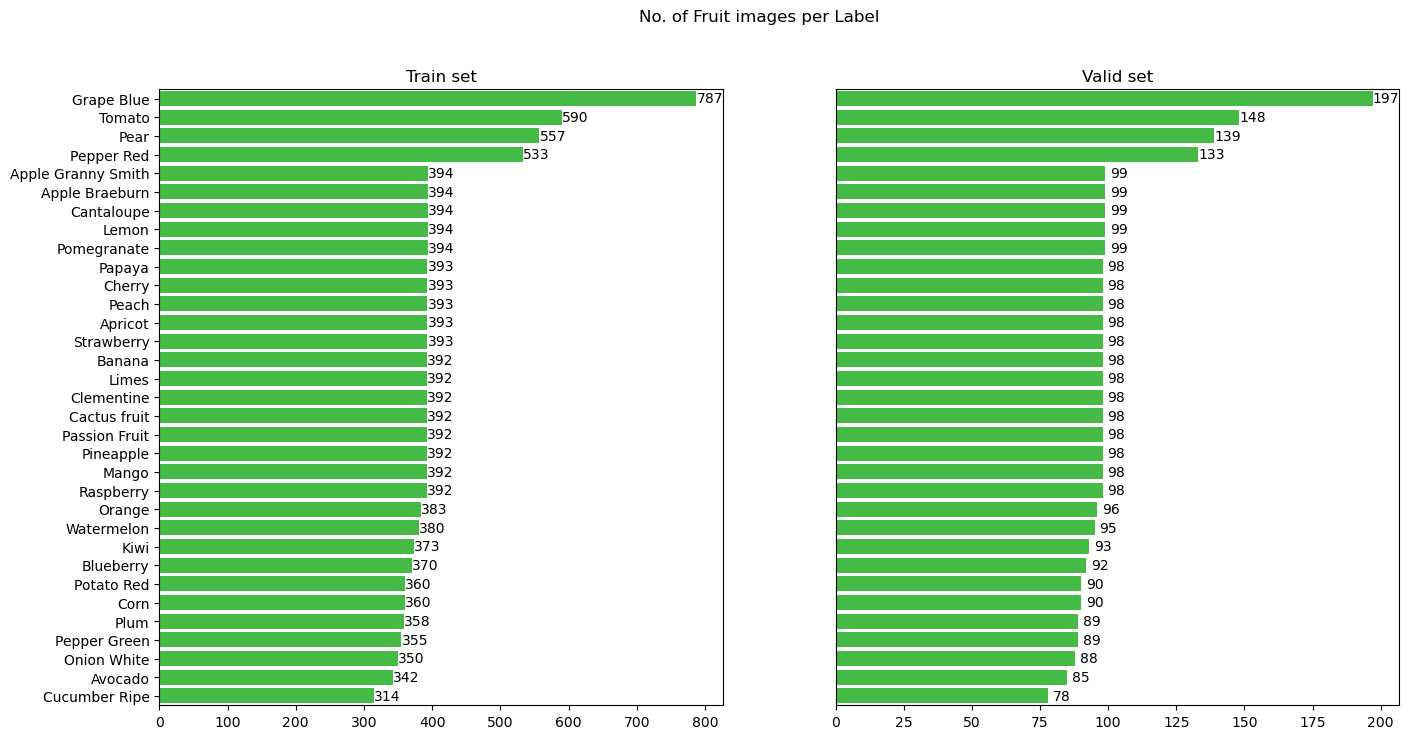

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

fig.suptitle("No. of Fruit images per Label")

# Display Train set
DisplayLabelCount(train_label_counter, ax = ax1)

for i, value in enumerate(train_label_counter.values()):
    ax1.text(value + 20, i, value, ha = "center", va = "center")
    
ax1.set_title("Train set")

# Display Valid set
DisplayLabelCount(valid_label_counter, ax = ax2)

for i, value in enumerate(valid_label_counter.values()):
    ax2.text(value + 5, i, value, ha = "center", va = "center")

ax2.yaxis.set_visible(False)
ax2.set_title("Valid set")

plt.show()

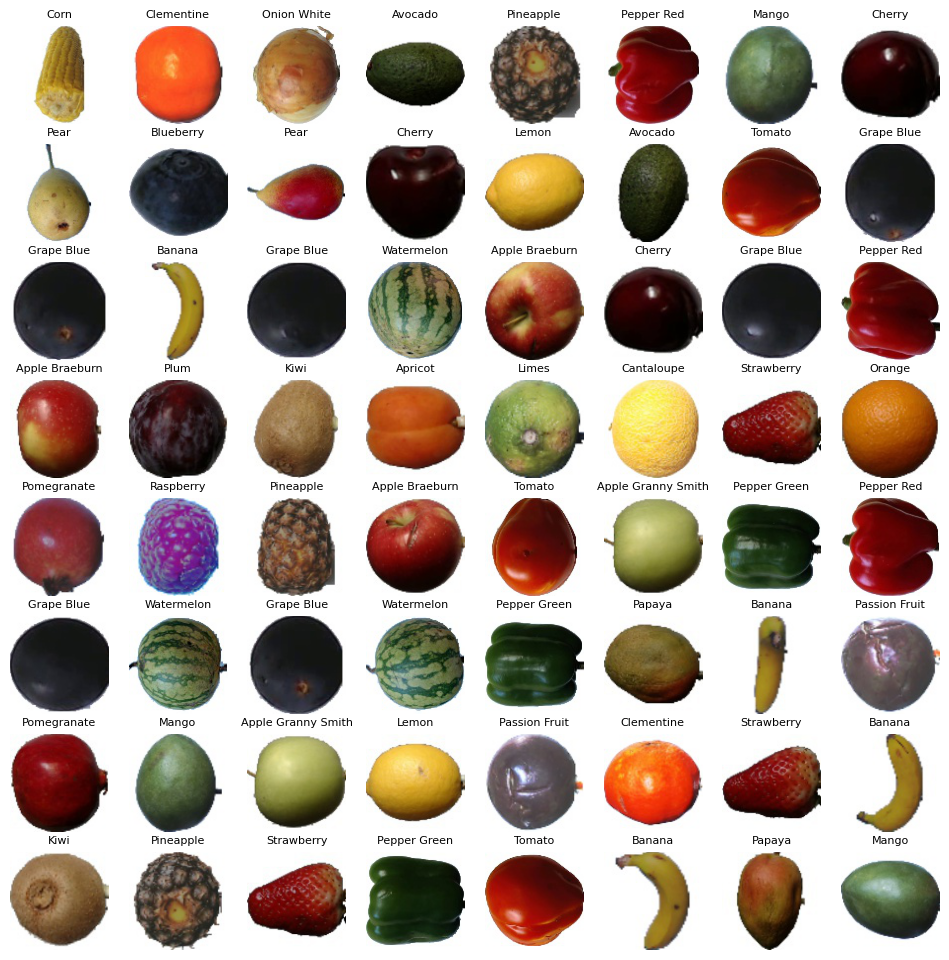

In [14]:
# Get a random batch of images
batch_images, batch_labels = next(iter(train_loader))

# Display the images
batch_imshow(batch_images, batch_labels, count = 64)

### <a id = "model">Modelling</a>

In [15]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride = 1):
        super(ResidualBlock, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = stride, padding = 1)
        self.bn_1 = nn.BatchNorm2d(out_ch)
        self.relu_1 = nn.ReLU(inplace = True)
        
        self.conv_2 = nn.Conv2d(out_ch, out_ch, kernel_size = 3, stride = 1, padding = 1)
        self.bn_2 = nn.BatchNorm2d(out_ch)
        
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu_2 = nn.ReLU(inplace = True)
    
    def forward(self, input):
        identity = input
        
        output = self.conv_1(input)
        output = self.bn_1(output)
        output = self.relu_1(output)
        
        output = self.conv_2(output)
        output = self.bn_2(output)
        
        output += self.shortcut(identity)
        output = self.relu_1(output)
        
        return output

# ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, prints = False):
        super(ResNet18, self).__init__()
        self.prints = prints
        
        self.in_ch = 64
        
        self.conv_1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn_1 = nn.BatchNorm2d(64)
        self.relu_1 = nn.ReLU(inplace = True)
        self.mp_1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer_2_1 = self._make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer_2_2 = self._make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer_2_3 = self._make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer_2_4 = self._make_layer(ResidualBlock, 512, 2, stride = 2)
        
        self.ap_3 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_3 = nn.Linear(512, 33)
    
    def _make_layer(self, block, out_ch, blocks, stride):
        layers = []
        layers.append(block(self.in_ch, out_ch, stride))
        self.in_ch = out_ch
        
        for _ in range(1, blocks):
            layers.append(block(out_ch, out_ch, stride = 1))
        
        return nn.Sequential(*layers)
    
    def forward(self, input):
        self.prints and print(f"Start")
        self.prints and print()
        
        self.prints and print(f"input.shape: {input.shape}")
        
        output = self.conv_1(input)
        self.prints and print(f"conv_1.shape: {output.shape}")
        output = self.bn_1(output)
        output = self.relu_1(output)
        output = self.mp_1(output)
        self.prints and print(f"mp_1.shape: {output.shape}")
        
        output = self.layer_2_1(output)
        self.prints and print(f"layer_2_1.shape: {output.shape}")
        output = self.layer_2_2(output)
        self.prints and print(f"layer_2_2.shape: {output.shape}")
        output = self.layer_2_3(output)
        self.prints and print(f"layer_2_3.shape: {output.shape}")
        output = self.layer_2_4(output)
        self.prints and print(f"layer_2_4.shape: {output.shape}")
        
        output = self.ap_3(output)
        self.prints and print(f"ap_3.shape: {output.shape}")
        output = output.view(output.size(0), -1)
        self.prints and print(f"reshape before fc: {output.shape}")
        output = self.fc_3(output)
        self.prints and print(f"fc_3.shape: {output.shape}")

        self.prints and print(f"End")
        self.prints and print()
        
        return output

In [16]:
rn18_model = ResNet18()
rn18_model.to(device) # Set prints = True to display tensor dimension per layer

ResNet18(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU(inplace=True)
  (mp_1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer_2_1): Sequential(
    (0): ResidualBlock(
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_1): ReLU(inplace=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
      (relu_2): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer_rn18_model = torch.optim.SGD(rn18_model.parameters(), lr = 0.001)

In [18]:
train_acc_list = []
train_loss_list = []

valid_acc_list = []
valid_loss_list = []

valid_labels_dict = {}
predicted_valid_labels_dict = {}

num_epochs = 5
train_label_counts = sum(train_label_counter.values())
valid_label_counts = sum(valid_label_counter.values())

'''
Check selected model and optimizer
1) model vs rn18_model
2) ptimizer_model vs optimizer_rn18_model
'''

for epoch in range(num_epochs):
    # Training
    rn18_model.train() # Change Model
    curr_train_loss = 0.0
    correct_train_predictions = 0

    for batch_images, batch_labels in tqdm(train_loader):
        # Set Parameter gradients to zero
        optimizer_rn18_model.zero_grad() # Change Optimizer
        
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        train_outputs = rn18_model(batch_images) # Change Model
        loss = criterion(train_outputs, batch_labels)
        loss.backward()
        optimizer_rn18_model.step() # Change Optimizer

        curr_train_loss += loss.item() * batch_images.size(0)
        _, predicted_train_labels = torch.max(train_outputs.data, 1)
        correct_train_predictions += (predicted_train_labels == batch_labels).sum().item()

    # Evaluating with Validation
    rn18_model.eval() # Change Model
    curr_valid_loss = 0.0
    correct_valid_predictions = 0
    
    with torch.no_grad():
        for valid_images, valid_labels in tqdm(valid_loader):
            valid_images = valid_images.to(device)
            valid_labels = valid_labels.to(device)

            valid_outputs = rn18_model(valid_images) # Change Model
            loss = criterion(valid_outputs, valid_labels)
            
            curr_valid_loss += loss.item() * valid_images.size(0)
            _, predicted_valid_labels = torch.max(valid_outputs.data, 1)
            correct_valid_predictions += (predicted_valid_labels == valid_labels).sum().item()

            # Populate dictionary for validation set confusion matrix
            key_name = f"epoch {epoch + 1}"
            if key_name not in valid_labels_dict:
                valid_labels_dict[key_name] = []
                predicted_valid_labels_dict[key_name] = []
                
            valid_labels_dict[key_name].append(valid_labels.tolist())
            predicted_valid_labels_dict[key_name].append(predicted_valid_labels.tolist())
    
    # Storing values
    curr_train_acc = round(correct_train_predictions / train_label_counts, 5)
    curr_train_loss = round(curr_train_loss / train_label_counts, 5)
    
    train_acc_list.append(curr_train_acc)
    train_loss_list.append(curr_train_loss)

    curr_valid_acc = round(correct_valid_predictions / valid_label_counts, 5)
    curr_valid_loss = round(curr_valid_loss / valid_label_counts, 5)
    
    valid_acc_list.append(curr_valid_acc)
    valid_loss_list.append(curr_valid_loss)

    print(f"Epoch: {epoch + 1} - Train Acc: {curr_train_acc} Valid Acc: {curr_valid_acc} Train Loss: {curr_train_loss} Valid Loss: {curr_valid_loss}")

100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


Epoch: 1 - Train Acc: 0.57517 Valid Acc: 0.85405 Train Loss: 2.46317 Valid Loss: 1.55047


100%|██████████| 1/1 [00:11<00:00, 11.05s/it]


Epoch: 2 - Train Acc: 0.91871 Valid Acc: 0.96233 Train Loss: 1.15931 Valid Loss: 0.71493


100%|██████████| 1/1 [00:10<00:00, 10.65s/it]


Epoch: 3 - Train Acc: 0.97278 Valid Acc: 0.98813 Train Loss: 0.5694 Valid Loss: 0.34814


100%|██████████| 1/1 [00:10<00:00, 10.28s/it]


Epoch: 4 - Train Acc: 0.99051 Valid Acc: 0.99792 Train Loss: 0.31494 Valid Loss: 0.20069


100%|██████████| 1/1 [00:10<00:00, 10.28s/it]

Epoch: 5 - Train Acc: 0.99644 Valid Acc: 0.9997 Train Loss: 0.20175 Valid Loss: 0.12236


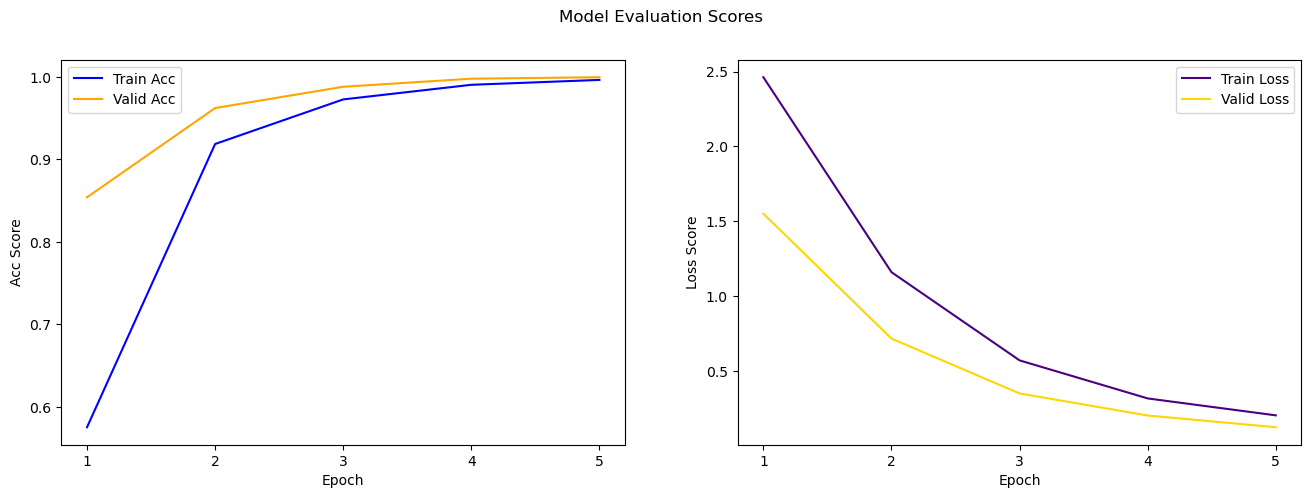

In [19]:
DisplayModelEvaluation(num_epochs, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list)

In [20]:
cmap = "RdPu"
cmap_obj = sns.color_palette(cmap, as_cmap = True)
nan_color = mcolors.rgb2hex(cmap_obj(0))

cmlist = []
annotlist = []

for step in np.arange(1, num_epochs + 1, 1):
    cm = confusion_matrix(valid_labels_dict[f"epoch {step}"][0], predicted_valid_labels_dict[f"epoch {step}"][0]).astype(float)

    full_annot = []
    for row in cm:
        row_perc = np.round((row / sum(row) * 100), 0)

        annot_row = []
        for r, p in zip(row, row_perc):
            annot_row.append(str(int(r)) + "\n" + str(int(p)) + "%")
            
        full_annot.append(annot_row)
        
    annotlist.append(full_annot)
    
    cm[cm == 0.0] = np.nan
    cmlist.append(cm)

# Create heatmaps
def display_heatmap(cm, epoch_no):    
    plt.figure(figsize = (22, 16))
    ax = sns.heatmap(cm, xticklabels = classes, yticklabels = classes, annot = annotlist[epoch_no - 1], fmt = "", cmap = cmap, linewidths = 0.5)
    ax.set_facecolor(nan_color)
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.show()

# Function to switch between different heatmaps
@interact(epoch_no = widgets.IntSlider(min = 1, max = 5, step = 1, value = 1))
def slider_heatmap(epoch_no):
    display_heatmap(cmlist[epoch_no - 1], epoch_no)

interactive(children=(IntSlider(value=1, description='epoch_no', max=5, min=1), Output()), _dom_classes=('widg…

Each box shows the frequency of classification based on the true and predicted labels, as well as the corresponding percentages relative to the total instances of the true label.

We can see that by analysing each epoch's confusion matrix, the model is able to correctly classify the fruits.
However, lets take a quick look at how each epoch faired.

<ol>
    <li>Epoch 1</li>
    <ul>
        <li>Model accuracy: 85.26%</li>
        <li>The model was poor in classifying Cactus Fruit 46%, Corn 63%, Cucumber Ripe 55%, Peach 28%, Pineapple 50%, Plum 74%, Pomegranate 53%, Potato Red 0% (percentages relative to total true label)</li>
        <li>Most of the incorrectly classified fruits are seen as Apple Braebum 28, Apricot 27, Cherry 24, Orange 37, Passion Fruit 20, Pears 64, Pepper Red 42, Strawberry 28 (times/instances)</li>
    </ul>
    <li>Epoch 2</li>
    <ul>
        <li>Model accuracy: 96.32%</li>
        <li>While there is massive improvement in all classes, the model is still poor in classifying Cactus Fruit 48%, Potato Red 59%</li>
        <li>It is still classifying incorrect fruits mostly as Pears 47, although there is good improvements (times/instances)</li>
    </ul>
    <li>Epoch 3</li>
    <ul>
        <li>Model accuracy: 98.81%</li>
        <li>The model has managed to classify Potato Red well, while Cactus Fruit has improved to 66%</li>
        <li>It has also reduced the incorrect classification of Pears</li>
    </ul>
    <li>Epoch 4</li>
    <ul>
        <li>Model accuracy: 99.79%</li>
        <li>The model has improved its classification of Cactus Fruit from 66% to 95%</li>
    </ul>
    <li>Epoch 5</li>
    <ul>
        <li>Model accuracy: 99.97%</li>
        <li>Almost all fruits are 100% correctly classified</li>
    </ul>
</ol>

In [21]:
if device.type == "cuda":
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage Allocated: {round(torch.cuda.memory_allocated(0) / 1024 ** 3, 5)} GB")
    print(f"Memory Usage Reserved (Cached): {round(torch.cuda.memory_reserved(0) / 1024 ** 3, 5)} GB")

Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage Allocated: 0.48268 GB
Memory Usage Reserved (Cached): 4.92969 GB


### <a id = "conclusion">Conclusion</a>

TODO

#### Things to do

- Up or Downsample, for inbalance of categories
- Data augmentation

#### Archived Code

##### Function to display batch images

In [22]:
# def batch_imshow(batch_images):
#     # Unnormalise images
#     img = torchvision.utils.make_grid(batch_images) / 2 + 0.5
#     np_img = img.numpy()
    
#     plt.imshow(np.transpose(np_img, (1, 2, 0)))

#     plt.axis("off")
#     plt.title("Training Images")
    
#     plt.show()

# batch_imshow(batch_images)

##### Another way of displaying confusion matrix with matplotlib
- Images are static, so you have to manually change epoch number

In [23]:
# epoch_no = 5 # Change as requested

# cm = confusion_matrix(valid_labels_dict[f"epoch {epoch_no}"][0], predicted_valid_labels_dict[f"epoch {epoch_no}"][0])

# plt.figure(figsize = (16, 12))

# sns.heatmap(cm, xticklabels = classes, yticklabels = classes, annot = True, fmt = "d", cmap = plt.cm.RdPu, linewidths = 0.5)

# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")

# plt.show()

##### Another way of displaying confusion matrix with plotly
- You can switch between confusion matrices with plotly slider, however it does not have annotations

In [24]:
# import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = 'iframe'

# fig = go.Figure()

# fig.add_trace(        
#     go.Heatmap(
#         z = confusion_matrix(valid_labels_dict[f"epoch {1}"][0], predicted_valid_labels_dict[f"epoch {1}"][0]),
#         x = classes, y = classes,
#         colorscale = "RdPu"
        
#     )
# )

# steps = []

# for step in np.arange(1, num_epochs + 1, 1):
#     cm = confusion_matrix(valid_labels_dict[f"epoch {step}"][0], predicted_valid_labels_dict[f"epoch {step}"][0])

#     # Steps
#     step = dict(
#         method = "update",
#         args = [
#             {
#                 "z": [cm]
#             }
#         ],
#         label = f"step {step}"
#     )
#     steps.append(step)
    
# sliders = [
#     dict(
#         active = 0,
#         currentvalue = {"prefix": "Epoch: "},
#         pad = {"t": 150},
#         steps = steps
#     )
# ]   

# fig.update_layout(
#     sliders = sliders,
#     title = "Confusion Matrix",
#     width = 1200, height = 1200
# )

# fig.update_xaxes(title_text = "Predicted Label", tickangle = 270)
# fig.update_yaxes(title_text = "True Label", autorange = "reversed")

# fig.show()